## Installs
pip install torch transformers biopython pandas torch torchviz matplotlib graphviz

# Data Preprocessing
Load data & labels

In [2]:
from Bio import SeqIO
import pandas as pd

def indexFasta(fasta_file):
    return set(record.id for record in SeqIO.parse(fasta_file, "fasta"))

def getLabel(recordId, indexes):
    for kingdom, ids in indexes.items():
        if recordId in ids:
            return kingdom
    return 'Unknown'

print("starting to index")
indexesSuperkingdom = {
    "Archaea": indexFasta("data/pretraining_dataset/Archaea_db.fa"),
    "Bacteria": indexFasta("data/pretraining_dataset/Bacteria_db.fa"),
    "Eukaryota": indexFasta("data/pretraining_dataset/Eukaryota_db.fa"),
    "Viruses": indexFasta("data/pretraining_dataset/Viruses_db.fa"),
}
print("done indexing")

starting to index
done indexing


## Validation & Training Datasets

In [59]:
train_file = 'data/final_model_dataset/train.fa'
val_file = 'data/final_model_dataset/test.fa'
dataTrain = []
dataVal = []

for i, record in enumerate(SeqIO.parse(train_file, "fasta")):
    if i > 100000:
        break
    dataTrain.append({
        "ID": record.id,
        "Sequence": str(record.seq),
        "SuperkingdomLabel": getLabel(record.id, indexesSuperkingdom)
    })
for i, record in enumerate(SeqIO.parse(val_file, "fasta")):
    if i > 75000:
        break
    dataVal.append({
        "ID": record.id,
        "Sequence": str(record.seq),
        "SuperkingdomLabel": getLabel(record.id, indexesSuperkingdom)
    })

df = pd.DataFrame(dataTrain)

dfVal = pd.DataFrame(dataVal)


# BERT LLM Model Architecture


In [60]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer

class TaxonomyClassifier(nn.Module):
    def __init__(self, bert_model, num_classes_superkingdom):
        super().__init__()
        self.bert = bert_model
        self.classifier_superkingdom = nn.Linear(self.bert.config.hidden_size, num_classes_superkingdom)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        superkingdom_logits = self.classifier_superkingdom(pooled_output)
        return superkingdom_logits

## Instantiating the Model

In [61]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
num_classes_superkingdom = 4  # The actual number of superkingdom classes you have

model = TaxonomyClassifier(bert_model, num_classes_superkingdom)

# Preparing the Data


## Tokenization
Not strictly necessary

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_data = tokenizer(df['Sequence'].tolist(), padding=True, truncation=True, return_tensors='pt')

## Datasets & Dataloaders

In [62]:
from torch.utils.data import Dataset, DataLoader
label_to_index = {
    "Eukaryota": 0,
    "Bacteria": 1,
    "Archaea": 2,
    "Viruses": 3
}

class SequenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, label_to_index):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.label_to_index = label_to_index

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sequence = self.dataframe.iloc[idx]['Sequence']
        label_str = self.dataframe.iloc[idx]['SuperkingdomLabel']
        label_idx = self.label_to_index[label_str]  # Convert label to index
        tokenized_sequence = self.tokenizer.encode(sequence)
        return torch.tensor(tokenized_sequence), torch.tensor(label_idx)


train_dataset = SequenceDataset(df, tokenizer, label_to_index)
val_dataset = SequenceDataset(dfVal, tokenizer, label_to_index)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


## Rendering an Image of the Model

In [44]:
from torchviz import make_dot

model_parameters = dict(model.named_parameters())

model.eval()
# For BERT, sequence_length is often 512
dummy_input_ids = torch.randint(0, 1000, (1, 512)) #token IDs
dummy_attention_mask = torch.ones(1, 512).long() # Attention Masks

with torch.no_grad():
    # Forward pass with dummy data to get the model output.
    dummy_output = model(dummy_input_ids, dummy_attention_mask)

if isinstance(dummy_output, tuple):
    dot = make_dot(dummy_output[0], params=model_parameters)
else:
    dot = make_dot(dummy_output, params=model_parameters)

# Save the graph to a file.
dot.render('full_model_architecture', format='png')


'full_model_architecture.png'

# Training

## Device Setup

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [64]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/taxonomyClassifactionModel1')

In [65]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # or another suitable loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    trainLosses = []
    valLosses = []
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch}")
        
        # Training phase
        model.train()
        total_train_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        trainLosses.append(avg_train_loss)

        # Log training loss
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        valLosses.append(avg_val_loss)

        # Log validation loss
        writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}")

    # Close the SummaryWriter
    writer.close()

    return trainLosses, valLosses


# Testing & Visualization

## Calling Training Function

In [ ]:
num_epochs = 101
train_losses, val_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)

Starting epoch 0
Epoch [1/101], Training Loss: 1.11746060199945


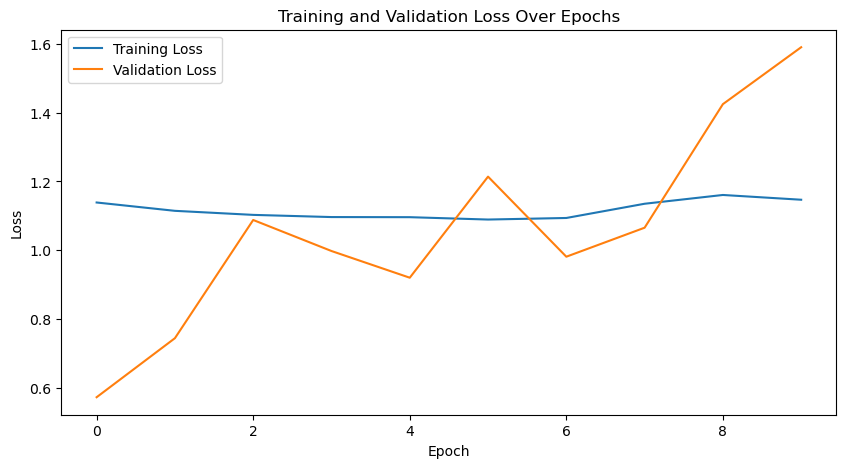

In [58]:
import matplotlib.pyplot as plt

# Assuming you have lists storing training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()